In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys
import scipy.io

import os
import datetime
import glob
import h5py
import copy


sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import jabble.model
import jabble.dataset
import jabble.loss
import jabble.quickplay

import astropy.coordinates as coord
import astropy.time as at
import astropy.units as u

jax.config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax/','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

<h1>03-Extract Data from KOA files</h1>
In this notebook, I extract the flux, wavelength, error data from many KOA data fits file. And store the important information in arrays that will used for fitting by jabble.

In [3]:
file_names = 'KOA_68585/HIRES/extracted/**/*_flux.fits' #+ ['KOA_123937_{}/HIRES/extracted/**/*_flux.fits'.format(x) for x in range(2,16)]
folder_names = os.path.join('/scratch/mdd423/wobble_jax/data/gj436_hires',file_names)
files = glob.glob(folder_names, 
                   recursive = True)

In [4]:
hdu1 = fits.open(files[0])

In [5]:
hdu1[0].header['*OBJ*']

OBJECT  = 'object (Flux)'                                                       
OBJFILE = 'HI.20080319.419:  167  500 none  ng3   kv370 -0.0290 -0.1290 B5'     
OBJPOS01= '-0.01956     1.66744'                                                
OBJPOS02= '-0.02326     1.66744'                                                
OBJPOS03= '-0.02440     1.66744'                                                
OBJPOS04= '-0.02373     1.66744'                                                
OBJPOS05= '-0.02196     1.66744'                                                
OBJPOS06= '-0.01984     1.66744'                                                
OBJPOS07= '-0.01810     1.66744'                                                
OBJPOS08= '-0.01748     1.66744'                                                
OBJPOS09= '-0.01871     1.66744'                                                
OBJPOS10= '-0.02251     1.66744'                                                
ARC2OBJ = 'Arc-167_3.fits Fl

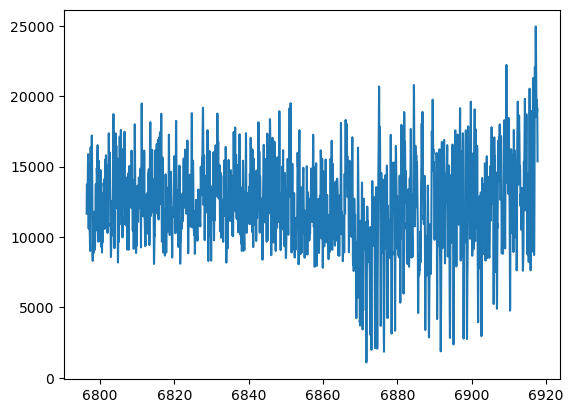

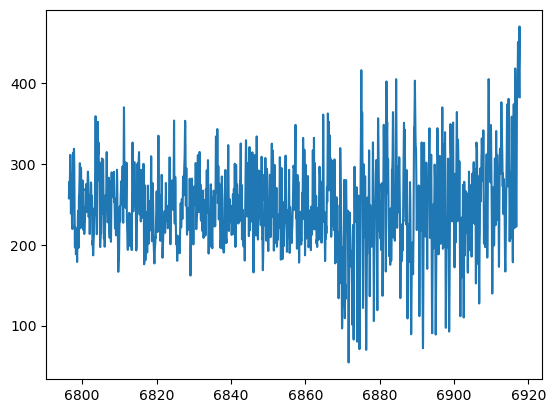

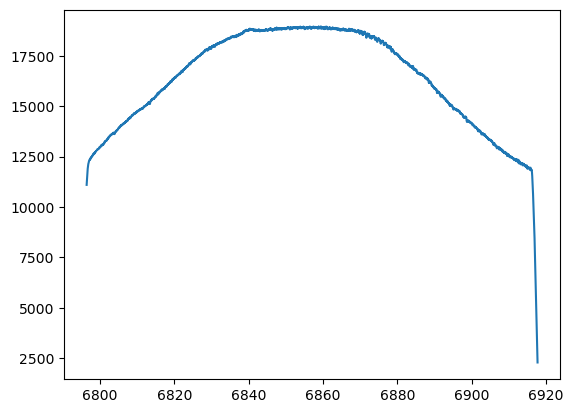

In [6]:
plt.plot(hdu1[1].data['wave'],hdu1[1].data['flux'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Background'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Flat'])
plt.show()

In [7]:
observatory_name = 'Keck'
loc = coord.EarthLocation.of_site(observatory_name)
star_name = hdu1[0].header['TARGNAME']
star = coord.SkyCoord.from_name(star_name,parse=True)

In [35]:
valid_target = ['36-Gl436(STD)', 'GJ 436', 'GJ436', 'HIP57087', 'gl436','gl436_M3V', 'hip 57087', 'hip57087']
valid_object = ['(Flux)', 'GJ 436 (Flux)', 'GJ 436 +I2 (Flux)', 'GJ436 (Flux)',\
        'HIP57087 (Flux)','Object (Flux)',\
        'Star+Iodine (Flux)',\
        'hip57087 (Flux)', 'k71 (Flux)', 'k72 (Flux)',\
        'k75 (Flux)', 'k80 (Flux)', 'k81 (Flux)', 'k82 (Flux)',\
        'k83 (Flux)', 'k86 (Flux)', 'k88 (Flux)', 'object (Flux)',\
        'star (Flux)']

def get_order_files(all_files):
    all_orders = []
    wavemins = []
    name_arr = []

    for filename in files:
        try:
            hdu1 = fits.open(filename)
            
            if hdu1[0].header['TARGNAME'] in valid_target:
                if hdu1[0].header['OBJECT'] in valid_object:
                    name_arr.append(filename)
                    all_orders.append(hdu1[0].header['ECHL_ORD'])
                    wavemins.append(np.min(hdu1[1].data['wave']))

            #         if hdu1[0].header['ECHL_ORD'] is echelle_order:
            #             try:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC'])#, format='isot', scale='utc')
            #             except:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT'])#, format='isot', scale='utc')
                    
            #             # print(hdu1[0].header['TARGNAME'],hdu1[0].header['OBJECT'])
                        
            #             # times.append(jd)
                        # wavemins.append(np.min(hdu1[1].data['wave']))
            #             # orders.append(hdu1[0].header['ECHL_ORD'])
                        
        except OSError:
            print(filename)
    assert len(all_orders) == len(name_arr)
    assert len(all_orders) == len(wavemins)
    
    for echelle_order in np.unique(all_orders):
        mask = np.array(all_orders) == echelle_order
        median_wave = np.median(np.array(wavemins)[mask])
        mask_waves = np.abs(np.array(wavemins) - median_wave) < 5
        total_mask = (~mask_waves.astype(bool)) * mask.astype(bool)

        indices, = np.where(total_mask)
        for index in sorted(indices,reverse=True):
            all_orders.pop(index)
            name_arr.pop(index)
            wavemins.pop(index)
    
    return name_arr, np.array(all_orders)
name_arr, all_orders = get_order_files(files)

/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_06_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_08_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_04_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_07_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_12_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_13_flux.fits
/scratch

In [36]:
len(name_arr),len(all_orders)

(10045, 10045)

In [ ]:
np.unique(valid_target),np.unique(valid_object)

<h2>Loading in Data from Directories Here</h2>
Searches the directory for all flux files as downloaded from Keck Online Archive (KOA).

In [64]:
def get_dataset(files,epsilon=np.exp(-11)):
    iteration = 0
    airmasses = np.zeros(shape=(0))
    bcs = np.zeros(shape=(0))
    jds = np.zeros(shape=(0))
    filenames = np.zeros(shape=(0))
    objnames = np.zeros(shape=(0))
    fluxes   = []
    waves    = []
    yivar    = []
    mask = []
    for file in files:
        
        try:
            hdu1 = fits.open(file)
        except:
            print(file)
            continue
            
        airmass = float(hdu1[0].header['AIRMASS'])
        
        flux = np.array(hdu1[1].data['flux'],dtype=np.float64)
        xs = np.log(jnp.array(hdu1[1].data['wave'],dtype=np.float64))
        ys = np.log(flux)
        yerr = np.array(hdu1[1].data['Error'],dtype=np.float64)/flux
        ma = np.isnan(yerr) | np.isinf(yerr) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux) | (yerr <= 0)
        objname = hdu1[0].header['OBJFILE']

        ys[ma] = 0.0
        xs[ma] = np.min(xs)
        yerr[ma] = 1e-13

        try:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC']), format='isot', scale='utc')
        except:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT']), format='isot', scale='utc')
            
        fluxes.append(ys)
        waves.append(xs)
        yivar.append(1/yerr**2)
        mask.append(ma)
        
        bc = star.radial_velocity_correction(obstime=jd, location=loc).to(u.m/u.s).value

        airmasses = np.concatenate((airmasses,[airmass]))
        bcs = np.concatenate((bcs,[bc]))
        jds = np.concatenate((jds,[jd.jd]))
        filenames = np.concatenate((filenames,[file]))
        objnames = np.concatenate((objnames,[objname]))
        
    dataset = jabble.dataset.Data.from_lists(waves,fluxes,yivar,mask)
    dataset.metadata['times'] = jds
    dataset.metadata['airmasses'] = airmasses

    return dataset, airmasses, bcs, jds

In [65]:
def get_normalization_model(dataset, norm_p_val: int, norm_pts: int):
    len_xs = np.max(
        [np.max(dataframe.xs) - np.min(dataframe.xs) for dataframe in dataset]
    )
    min_xs = np.min([np.min(dataframe.xs) for dataframe in dataset])
    max_xs = np.max([np.max(dataframe.xs) for dataframe in dataset])

    shifts = jnp.array([dataframe.xs.min() - min_xs for dataframe in dataset])
    x_spacing = len_xs / norm_pts
    x_grid = jnp.linspace(-x_spacing*((norm_p_val + 1)//2), len_xs + (x_spacing*((norm_p_val + 1)//2)), norm_pts + norm_p_val + 1) + min_xs
    model = jabble.model.CardinalSplineMixture(x_grid, norm_p_val)
    size = len(dataset)

    p = jnp.tile(model.p, size)
    norm_model = jabble.model.NormalizationModel(p, model, size)
    return jabble.model.ShiftingModel(shifts).composite(norm_model)

def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(jnp.array(airmass)),
        ]
    )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [66]:
def train_norm(model, dataset, loss, device_store, device_op, batch_size,nsigma = [0.5,2], maxiter=3):
    options = {"maxiter": 10,\
               "factr": 1e4,\
              }
    # Fit Normalization Template
    for iii in range(maxiter):
        model.fix()
        model.fit(2, 1)
        
        res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
        print(res1)
        model.fix()
        _,metablock = dataset.blockify(device_op)
        for data_epoch in range(len(dataset)):

            mask    = dataset[data_epoch].mask
            metarow = jabble.loss.dict_ele(metablock,data_epoch,device_op)
            resid = dataset[data_epoch].ys - model([],dataset[data_epoch].xs,metarow)
            sigma = np.sqrt(np.nanmedian(resid**2))
            m_new = (resid < -nsigma[0]*sigma) | (resid > nsigma[1]*sigma)
            dataset[data_epoch].mask = mask | m_new[:len(mask)]

    return model

def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 8,\
               "factr": 10.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # search_space = np.linspace(-100, 100, 500)
    # shift_search = jabble.physics.shifts(search_space)

    # sgrid = model[0][0].p[:,None] + shift_search[None,:]
    # lgrid = model[0][0].grid_search(sgrid, loss, model, dataset, device_op)
    
    # for i in range(lgrid.shape[0]):
    #     if np.argmin(lgrid[i,:]) == 0 or np.argmin(lgrid[i,:]) == lgrid.shape[1] - 1:
    #         plt.plot(shift_search,lgrid[i,:])
    #         plt.show()
    
    # model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    # model.to_device(device_op)

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)
    model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [67]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

echelle_order = int(70)
resolution = 85_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1e-7

norm_p_val = 3
norm_pts   = 4

star_name = 'GJ436'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)
print(np.unique(all_orders))

[ 39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98 119]


In [ ]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000

for echelle_order in [echelle_order]:
    
    data_name = os.path.join(out_dir,star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
    model_name = os.path.join(out_dir,star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))
    if not os.path.isfile(model_name) or True:
        # order_files, _ = get_order_files(files,echelle_order)
        name_mask = (echelle_order == all_orders)
        print(echelle_order,np.sum(name_mask))
        # print(echelle_order,np.sum(name_mask))
        if np.sum(name_mask) > 100:
            
            dataset, airmasses, bcs, jds = get_dataset(np.array(name_arr)[name_mask])
            norm_dataset = copy.deepcopy(dataset)
            print(np.sum(dataset.xs),np.sum(dataset.yivar),np.sum(dataset.ys))
            init_rvs = bcs
            rest_rvs = np.zeros(init_rvs.shape)#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']
            print(init_rvs.shape,rest_rvs.shape)
            dataset.metakeys['times'] = jds
            
            model =  get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,airmasses)
            norm_model = get_normalization_model(dataset,norm_p_val,norm_pts)
            model += norm_model
            # print(dataset.yivar)
            reg_s = lmb*jabble.loss.L2Reg([0,1]) * np.nansum(dataset.yivar)
            reg_t = lmb*jabble.loss.L2Reg([1,1]) * np.nansum(dataset.yivar)
            model.metadata = dataset.metadata
    
            loss = jabble.loss.ChiSquare()
    
            model.display()
    
            model = train_norm(model, norm_dataset, loss, device_store, device_op, batch_size,maxiter=2,nsigma=[1,3])
            model = train_cycle(model, dataset, loss + reg_s + reg_t, device_store, device_op, batch_size)
    
            rv_model = model
            for ii in [0,0]:
                rv_model = rv_model[ii]
            rv_model.display()
            
            jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
    else:
        print('skipping order {}'.format(echelle_order))

70 188


/state/partition1/job-799616/ipykernel_3869091/1391192897.py:24: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux)


6509005.480477099 3.169999999999998e+28 6381865.835700627
(188,) (188,)
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-CardinalSplineMixture---------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture---------------------------------------0
  1  2-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NormalizationModel------------------------------------------0


In [56]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    # yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    yhat_norm_mask = model[2]([],dataset.xs[plt_epoch][datarow["mask"]],metarow)

    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)

    axes[0].set_xlim(xplot.min(),xplot.max())

    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=0.5,alpha=0.3,ms=1)

    axes[0].plot(datarow["xs"][datarow["mask"]],datarow["ys"][datarow["mask"]] - yhat_norm_mask,\
                     '.b',zorder=0.5,alpha=0.3,ms=1)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Telluric M
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    # axes[0].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    

    axes[0].set_ylim(-1.2,0.5)
    axes[1].set_ylim(-0.5,0.5)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

def make_subplot_norm(axes,model,dataset,norm_dataset,plt_epoch,device,lrange,nsigma):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    if isinstance(norm_dataset,jabble.dataset.Data):
        ndata,nmeta = norm_dataset.blockify(device)
        ndatarow = jabble.loss.dict_ele(ndata,plt_epoch,device)
        nmetarow = jabble.loss.dict_ele(nmeta,plt_epoch,device)
        axes.errorbar(ndatarow["xs"][~ndatarow["mask"]],ndatarow["ys"][~ndatarow["mask"]],\
                     yerr=1/np.sqrt(ndatarow["yivar"][~ndatarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=2)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    axes.set_xlim(xplot.min(),xplot.max())

    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes.errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.3,ms=1)

    
    # Stellar Model        
    # axes.plot(xplot,yplot_norm_stel + yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # # Telluric M
    # axes.plot(xplot,yplot_norm_tell + yplot_norm,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    axes.plot(xplot,yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)

    # axes.plot(xplot,yplot_norm+nsigma[1],'-m',linewidth=1.2,zorder=10,alpha=0.35,ms=6)
    # axes.plot(xplot,yplot_norm-nsigma[0],'-m',linewidth=1.2,zorder=10,alpha=0.35,ms=6)

    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    # axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
    #                          'k',where='mid',zorder=1,alpha=0.3,ms=3)

    # if "orders" in model.metadata:
        
    #     axes[0].text(np.log(lrange.min()+0.1),0.3,"Order: ${}$".format(model.metadata["orders"][plt_epoch]))
    # axes[0].text(np.log(lrange.max()-0.1),0.3,"MJD: ${}$".format(model.metadata["times"][plt_epoch]))

    # axes[0].set_ylim(-2.5,0.5)
    # axes.set_ylim(-5,0)
    
    # axes[0].set_xticks([])
    axes.set_xticks(np.log(lrange))
    # axes[1].set_xticks(np.log(lrange))

    axes.set_xticklabels(['{}'.format(x) for x in lrange])
    # axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    # axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

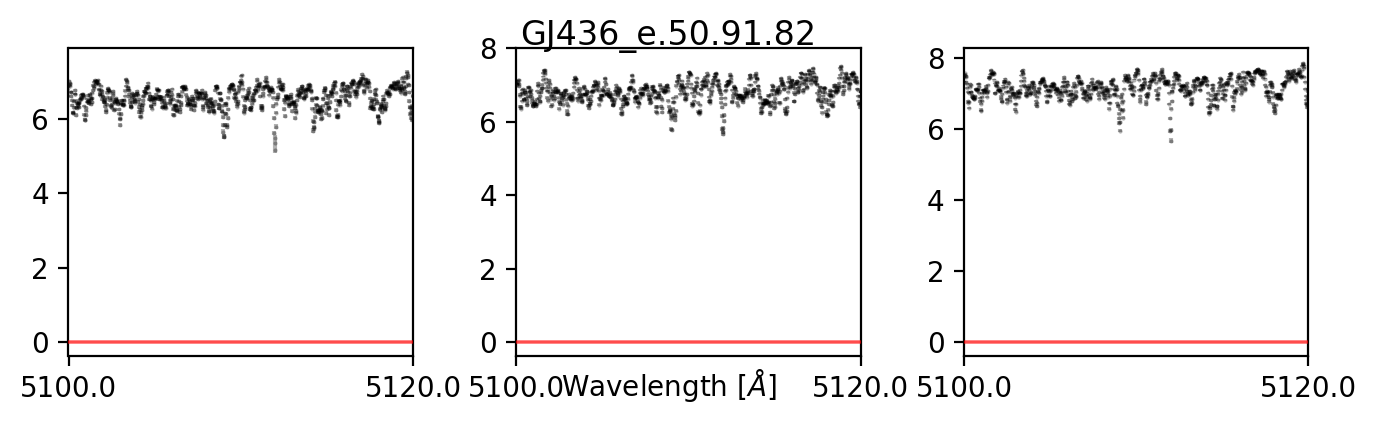

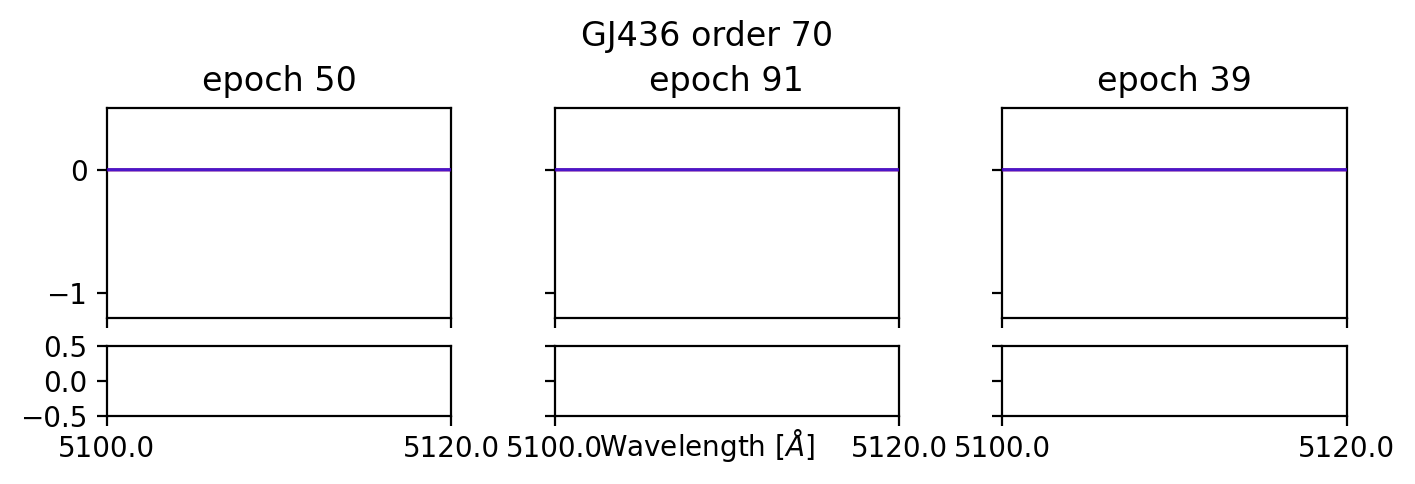

In [57]:
sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])

plt_epoches = [sorted_epoches[0],sorted_epoches[1],sorted_epoches[2]]

fig, axes = plt.subplots(1,len(plt_epoches),figsize=(8,2),sharex='col',sharey=False,\
                             facecolor=(1, 1, 1),dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]
lrange = np.linspace(5100,5120,2)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    axes[ii] = make_subplot_norm(axes[ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,2])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    # axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])

    epoch_str += '.' + str(plt_epoch)
plt_name = os.path.join(out_dir,"{}_spectra_norm_l{}-{}_e{}.png".format(star_name,lrange.min(),lrange.max(),epoch_str))

fig.suptitle('{}_e{}'.format(star_name,epoch_str),y=0.95)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt.savefig(plt_name)
plt.show()


sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])
plt_epoches = [sorted_epoches[0],sorted_epoches[1],sorted_epoches[-1]]

fig, axes = plt.subplots(2,len(plt_epoches),figsize=(8,2),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[3,1],dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# plt_width = np.arange(-40,40,20) + 10
# plt_epoch = 19

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]
lrange = np.linspace(5100,5120,2)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    # axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,3])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
    axes[0,ii].set_title('epoch {}'.format(plt_epoch))
    epoch_str += '.' + str(plt_epoch)
plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,\
                                                                       lrange.min(),lrange.max(),\
                                                                       epoch_str,echelle_order))

fig.suptitle('{} order {}'.format(star_name,echelle_order),y=1.1)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt.savefig(plt_name)
plt.show()